# Credit Survival Risk Analytic

## Background

Financial institutions used credit risk analysis models to determine the probability of default of a potential borrower.  The models provide information on the level of a borrower’s credit risk at any particular time. If the lender fails to detect the credit risk in advance, it exposes them to the risk of default and loss of funds. Lenders rely on the validation provided by credit risk analysis models to make key lending decisions on whether or not to extend credit to the borrower and the credit to be charged.

Here, we are building a credit risk analytic model using statistical method - **Survival analysis**. Survival analysis is a popular analytic methodology to investigate the expected duration of time until an event of interest occurs.

Some examples of what lender can dig in the loan and payment data are:
- What are the certain characteristics of borrower that defaulted?
- Are there similarities in default rates between groups of defaulted borrower?
- What are the possibility of borrower defaulted after a certain amount of time?

In this notebook, we will build a survival analysis that helps to answer these questions.<br> 
Kindly take note that this is a Proof of Concept (POC) model, that is still a lot more to discover out there!

## Import Library

In [1]:
# load libraries
'''
Data Handler Module
'''
import pandas as pd
import numpy as np
import shutil
'''
Plot Visualization Module
'''
import seaborn as sns
from matplotlib import pyplot as plt
'''
SKLearn Module
'''
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, OneHotEncoder
'''
SKSurv Module
'''
from sksurv.preprocessing import OneHotEncoder
from sksurv.ensemble import RandomSurvivalForest
'''
MLFlow Model Deployment Module
'''
import mlflow
from pathlib import Path
from mlflow.tracking import MlflowClient
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus
from mlflow.models.signature import infer_signature
'''
Survival Analysis Module
'''
from lifelines import KaplanMeierFitter
'''
Imbalanced Data Module
'''
from imblearn.over_sampling import RandomOverSampler
'''
Custom Library
'''
from feature_transformer import PipelineFeatureTransformer

## Data Preparation

### Loading & Pre-cleaning

Merging **loan.csv**, **payment.csv**, **clarity_underwriting.csv** into master_data

In [2]:
# Load Dataset 1 - Load.csv
raw_loan_data = pd.read_csv('data/loan.csv', parse_dates=['applicationDate','originatedDate'])
# Load Dataset 2 - payment.csv
raw_payment_data = pd.read_csv('data/payment.csv', parse_dates=['paymentDate'])
# Load Dataset 3 - clarity_underwriting_variables.csv
# For underwriting_data, we only need 2 columns underwritingid & clarityFraudId
raw_underwriting_data = pd.read_csv('data/clarity_underwriting_variables.csv', usecols=['underwritingid','clearfraudscore'])

Pre-cleaning & pre-feature Engineering on payment_data due to it's non-uniqueness ID.<br>
The objective here is to prepare a valid data for train-test spliting purpose.

Count plot here is showing that there are more than 200,000 data on paymentStatus as **Checked**, which is sufficient enough for us to do the analysis.

<AxesSubplot:xlabel='count', ylabel='paymentStatus'>

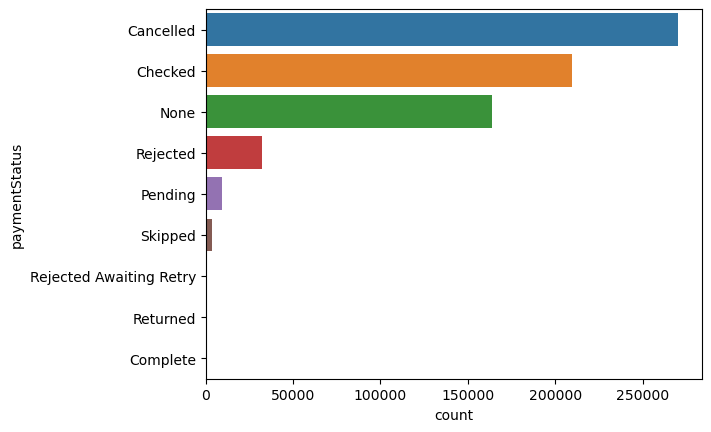

In [3]:
sns.countplot(data=raw_payment_data, 
              y='paymentStatus',
              order = raw_payment_data['paymentStatus'].value_counts().index)

And we only interested in payment that was **Checked** Or **Complete**

In [4]:
# Data Cleaning, retain only Checked/Complete payment
payment_data = raw_payment_data[np.logical_or(raw_payment_data['paymentStatus']=='Checked', raw_payment_data['paymentStatus']=='Complete')]

Summarize behavior of each loanIDs and generate new features:<br>
1. balanceOnLastDay
2. lastPaymentDate
3. noOfInstallmentMade
4. avgInstallmentAmountPerPayFrequency

In [5]:
def summarize_payment_profile(group):
    a = round(group['principal'] + group['fees'] - group['paymentAmount'].sum(), 2)
    b = group.sort_values(by='paymentDate')['paymentDate'].iloc[-1]
    c = group['installmentIndex'].count()
    d = (group['principal'] + group['fees']).mean()
    cols = ['balanceOnLastDay','lastPaymentDate','noOfInstallmentMade', 'avgInstallmentAmountPerPayFrequency']
    return pd.Series([a,b,c,d], index=cols)

payment_data = payment_data.groupby('loanId').apply(summarize_payment_profile).reset_index()

### Merging

Now payment_data has its unique loanID ready to be merged with another 2 datasets

In [6]:
# Inner join loan_data with payment_data
loan_payment_data = pd.merge(raw_loan_data, payment_data, on=['loanId'], how='inner')
# left join loan_payment_data with underwriting data
master_data = pd.merge(loan_payment_data, raw_underwriting_data, left_on=['clarityFraudId'], right_on=['underwritingid'], how='left')

Since all of the null loanId is associated with NaN for the rest of features, we can simply remove them. <br>

In [7]:
# Display null loadId
master_data[master_data['loanId'].isnull()].describe(include='all')

C:\Users\asust\AppData\Local\Temp\ipykernel_1196\1670275279.py:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  master_data[master_data['loanId'].isnull()].describe(include='all')


,loanId,anon_ssn,payFrequency,apr,applicationDate,originated,originatedDate,nPaidOff,approved,isFunded,...,leadCost,fpStatus,clarityFraudId,hasCF,balanceOnLastDay,lastPaymentDate,noOfInstallmentMade,avgInstallmentAmountPerPayFrequency,clearfraudscore,underwritingid
count,0,0,0,0.0,0,0,0,0.0,0,0.0,...,0.0,0,0,0.0,0,0,0.0,0.0,0.0,0
unique,0,0,0,NaN,0,0,0,NaN,0,NaN,...,NaN,0,0,NaN,0,0,NaN,NaN,NaN,0
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# Remove null loanId since null loanId do not have meaningful data
master_data = master_data.dropna(how='any',axis=0, subset=['loanId'])

Our objective here is to predict risk of default, we only require historical funded data. Let's remove row **approved** = False Or **isFunded** = 0.<br>
Before that, let's see if there is any condition such that <br>
**isFunded** = 1 while **approved** = 0

In [9]:
any(np.logical_and(master_data['approved'] == False, master_data['isFunded'] == 1))

False

In [10]:
master_data.isFunded.value_counts()

1    31842
0      326
Name: isFunded, dtype: int64

In [11]:
# Remove failed approved (for this use case)`
indexes = master_data[np.logical_or(master_data['approved'] == False, master_data['isFunded'] == 0)].index
master_data.drop(indexes,inplace=True)
# Display data size
master_data.shape

(31842, 25)

### Generate Targets Variables

In credit survival analysis, there are 2 targets:
- survival Duration = Last Payment Date - OriginatedDate
- loanStatus = 0/1

In [12]:
# Create survivalDuration feature
master_data['survivalDuration'] = master_data['lastPaymentDate'] - master_data['originatedDate']
# Convert from TimedeltaProperties into float
master_data['survivalDuration'] = master_data['survivalDuration'] / pd.to_timedelta(1, unit='D')

loanStatus is grouped into 2 categories:
- Category 0: Signify that customers defaulted
- Category 1: Signify that customers can either be no yet defaulted or censored (Event Occured)

<AxesSubplot:xlabel='count', ylabel='loanStatus'>

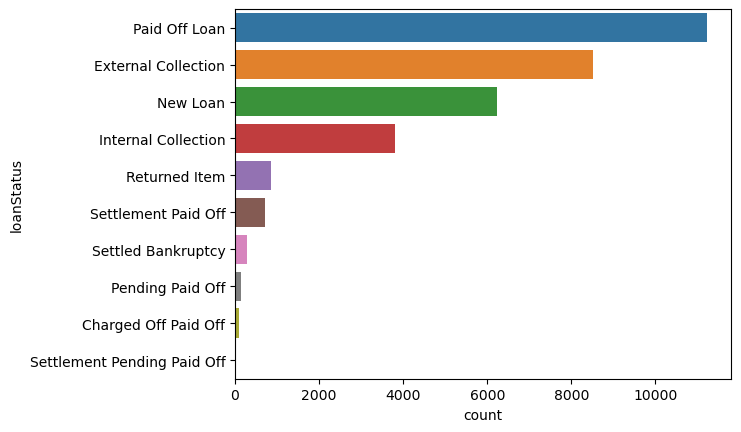

In [13]:
artifact1 = sns.countplot(data=master_data, 
                          y='loanStatus',
                          order = master_data['loanStatus'].value_counts().index)
artifact1

In [14]:
# loanStatus
labels = {0:['Returned Item', 'Charged Off Paid Off', 'Settled Bankruptcy', 'Charged Off'],
          1:['Paid Off Loan','Settlement Paid Off', 'New Loan', 'Internal Collection',
           'External Collection', 'Pending Paid Off', 'Settlement Pending Paid Off']}

def map_default(x):
    """
    Check if loanStatus if present in the labels dict
    params:
    x = loanStatus, string
    
    returns: label (int)
    """
    for k,v in labels.items():
        if x.loanStatus in v:
            return k

master_data['loanStatus'] = master_data.apply(map_default, axis=1)

### Train-Validation-Test Split

Master data is now ready to perform stratify train-validation-test splitting.<br>
The advantages of performing a **train-validation-test** splitting instead of **traditional train-test** splitting is well-explained in link below: <br>
https://towardsdatascience.com/when-training-a-model-you-will-need-training-validation-and-holdout-datasets-7566b2eaad80

In [15]:
def get_x_y_survival(dataset, col_event, col_time, val_outcome):
    if col_event is None or col_time is None:
        y = None
        x_frame = dataset
    else:
        y = np.empty(dtype=[(col_event, np.bool), (col_time, np.float64)],
                        shape=dataset.shape[0])
        y[col_event] = (dataset[col_event] == val_outcome).values
        y[col_time] = dataset[col_time].values

        x_frame = dataset.drop([col_event, col_time], axis=1)

    return x_frame, y

X_rf, y_rf = get_x_y_survival(master_data, 'loanStatus', 'survivalDuration', 1)
# Train - Test Split with ratio of 80:20
X_train, X_test, y_train, y_test = train_test_split(X_rf, 
                                                    y_rf, 
                                                    test_size=0.2,
                                                    random_state=1)
# Train - Validation Split with ratio of 75:25
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.25, 
                                                  random_state=1) # 0.25 x 0.8 = 0.2
# Pack Train Data
train_data = pd.DataFrame(X_train, columns=master_data.drop(['loanStatus', 'survivalDuration'], axis=1).columns.tolist())
train_data['loanStatus'] = [x[0] for x in y_train]
train_data['survivalDuration'] = [y[1] for y in y_train]
# Pack Test Data
test_data = pd.DataFrame(X_test, columns=master_data.drop(['loanStatus', 'survivalDuration'], axis=1).columns.tolist())
test_data['loanStatus'] = [x[0] for x in y_test]
test_data['survivalDuration'] = [y[1] for y in y_test]
# Pack Validation Data
validation_data = pd.DataFrame(X_val, columns=master_data.drop(['loanStatus', 'survivalDuration'], axis=1).columns.tolist())
validation_data['loanStatus'] = [x[0] for x in y_val]
validation_data['survivalDuration'] = [y[1] for y in y_val]

C:\Users\asust\AppData\Local\Temp\ipykernel_1196\2025152796.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty(dtype=[(col_event, np.bool), (col_time, np.float64)],


Stratify split is not allowed here due to missing values in some feature columns. It is not encouragable to perform missing value imputation on master data before the splitting due to result bias. A good practise is to carry out data cleaning, EDA, and features engineering on train data alone (after the split). <br>
Still, we have balanced distribution of target variables in train-validation-test data without stratify. (700 for train, 200 for test & validation)

Text(0.5, 1.0, 'ValidationData Loan Status')

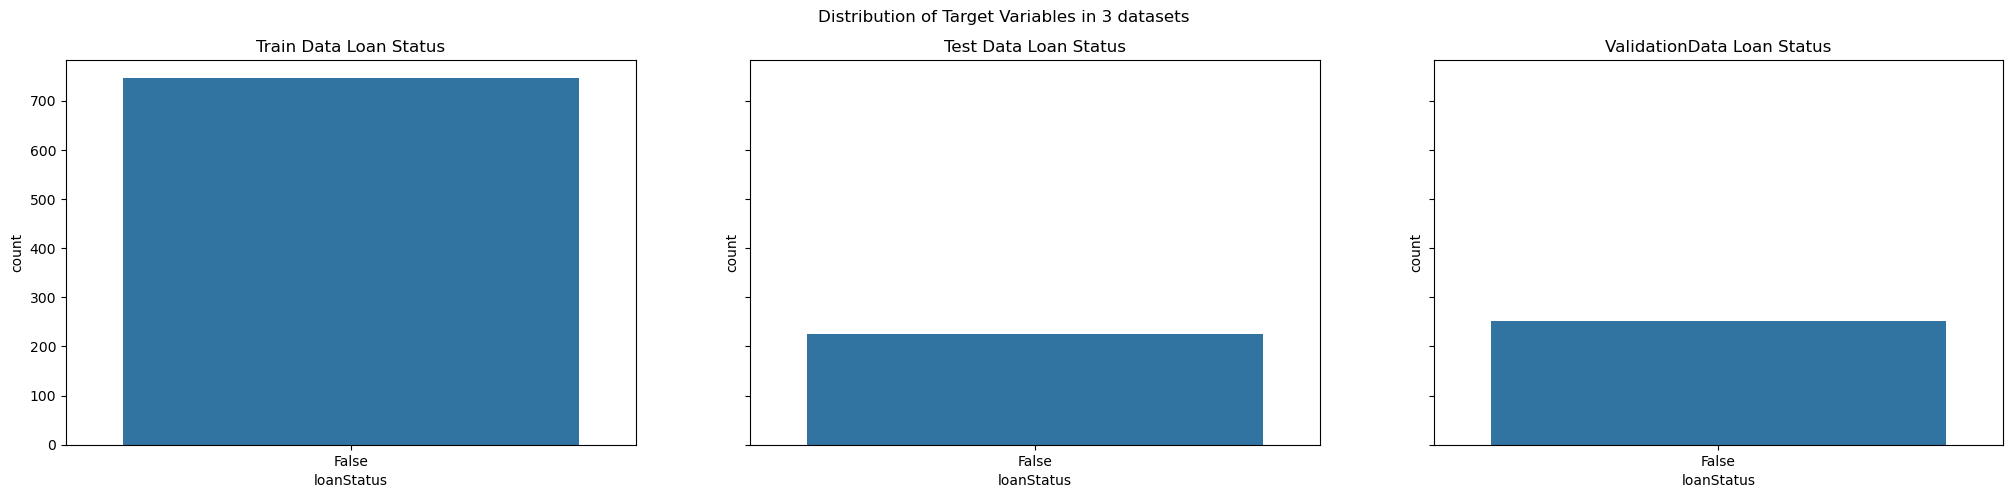

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=True)
fig.suptitle('Distribution of Target Variables in 3 datasets')

# Month
sns.countplot(ax=axes[0], data=train_data[train_data['loanStatus']==False], x= 'loanStatus')
axes[0].set_title("Train Data Loan Status")

# Year
sns.countplot(ax=axes[1], data=test_data[test_data['loanStatus']==False], x= 'loanStatus')
axes[1].set_title("Test Data Loan Status")

# Season
sns.countplot(ax=axes[2], data=validation_data[validation_data['loanStatus']==False], x= 'loanStatus')
axes[2].set_title("ValidationData Loan Status")

Now, the train dataset is ready for EDA!

## Exploratory Data Analysis

Do noted that this step is recorded in customTransformer.py. We will use SKlearn Pipeline to create series of job, so that the similar operation can be done in our test & validation data too!

### Survival Duration

The distribution is right-skewed due to some payments by minority of population are long-term borrower.

C:\Users\asust\AppData\Local\Temp\ipykernel_1196\4022841855.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  artifact2 = sns.distplot(train_data['survivalDuration'], kde = False, bins = 50)


<AxesSubplot:xlabel='survivalDuration'>

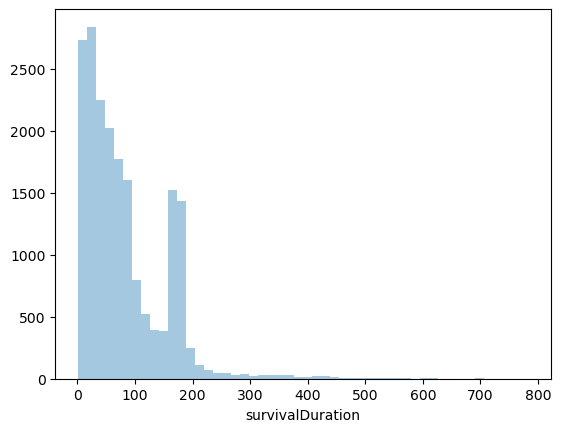

In [17]:
artifact2 = sns.distplot(train_data['survivalDuration'], kde = False, bins = 50)
artifact2

<AxesSubplot:xlabel='paymentDate', ylabel='paymentAmount'>

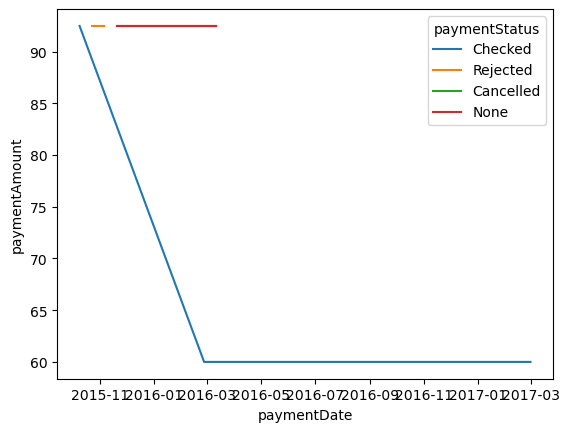

In [18]:
# Track the loanId for survivalDuration > 500
train_data[train_data['survivalDuration'] > 500] #loanId: LL-I-03506406 
raw_payment_data[raw_payment_data['loanId'] == 'LL-I-03506406'][['paymentStatus','paymentDate']]
artifact3 = sns.lineplot(data=raw_payment_data[raw_payment_data['loanId'] == 'LL-I-03506406'], 
                         x = 'paymentDate',
                         y = 'paymentAmount',
                         hue = 'paymentStatus')
artifact3

### Loan Status

Here, **loanStatus = True** signify that Event Occured (from survival analysis POV) <br>
**loanStatus = False** signify that borrower is defaulted. <br>
The dataset is imbalanced, oversampling on minority class is needed at the end of EDA 

<AxesSubplot:xlabel='count', ylabel='loanStatus'>

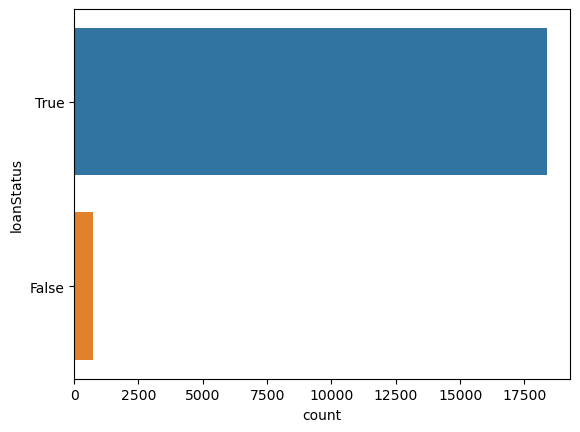

In [19]:
artifact4 = sns.countplot(data=train_data, 
                          y='loanStatus',
                          order = train_data['loanStatus'].value_counts().index)
artifact4

### Univariate Analysis in Probability of Survival

The most popular univariate method in Survival Analysis is the **Kaplan-Meier estimator**. In the non-parametric methods there are no dependencies on the form of parameters in underlying distributions. Mostly, the non-parametric approach is used to describe survival probabilities as function of time and to give an average view of individual’s population. 

Using Kaplan-Meier estimator, we can break the estimation of the survival function S(t) into smaller steps depending on the observed event times. For each interval the probability of surviving until the end of this interval is calculated, given the following formula:

$$\hat S(t) = \sum \limits_{i:t_{i}<=t} \frac{n_{i}-d_{i}}{n_{i}} $$
where $n_{i}$ is a number of individuals who are at risk at time point $t_{i}$ and $d_{i}$ is a number of subjects that experienced the event at time $t_{i}$.

In the plot below, it is clear that for days = 100 days the probability that borrowers are not default is about 30%.

Text(0, 0.5, 'Probability a Borrower is not default')

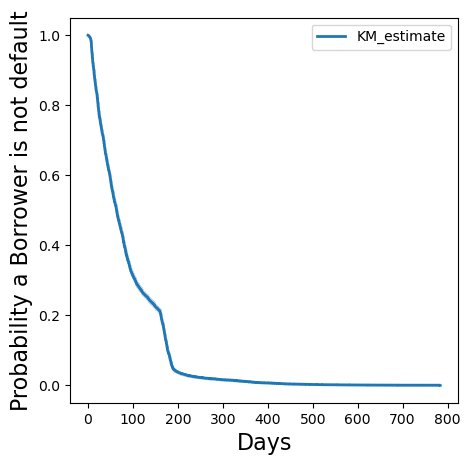

In [20]:
kmf = KaplanMeierFitter()

T = train_data["survivalDuration"]
E = train_data["loanStatus"]

kmf.fit(T, event_observed=E)
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111)
kmf.plot(ax=ax, linewidth = 2)
ax.set_xlabel('Days', size = 16)
ax.set_ylabel('Probability a Borrower is not default', size = 16)

## Features Engineering

### Seasonal Features

Let's create some new features from **lastPaymentDate**: **lastPaymentMonth**, **lastPaymentYear**, **lastPaymentSeason**.
And evaluate if these features affected the risk of default here.

In [21]:
# Create new features Month, Year, Season
labels = {"Spring": [3, 4, 5], 
          "Summer": [6, 7, 8],
          "Autumn": [9, 10, 11],
          "Winter": [12, 1, 2]}

def map_season(x):
    """
    Map Months into their respective season
    
    returns: label (str)
    """
    for k,v in labels.items():
        if x in v:
            return k

train_data['lastPaymentMonth'] = train_data['lastPaymentDate'].dt.month
train_data['lastPaymentYear'] = train_data['lastPaymentDate'].dt.year
train_data['lastPaymentSeason'] = train_data['lastPaymentMonth'].map(map_season)

Normalize the occurence to avoid bias due to imbalanced data

C:\Users\asust\AppData\Local\Temp\ipykernel_1196\2833466627.py:15: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(ax=axes[0], data=df1, y= 'lastPaymentMonthperc', x='lastPaymentMonth', ci=95)
C:\Users\asust\AppData\Local\Temp\ipykernel_1196\2833466627.py:19: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(ax=axes[1], data=df2, y= 'lastPaymentYearperc', x='lastPaymentYear', ci=95)
C:\Users\asust\AppData\Local\Temp\ipykernel_1196\2833466627.py:23: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.barplot(ax=axes[2], data=df3, y= 'lastPaymentSeasonperc', x='lastPaymentSeason', ci=95)


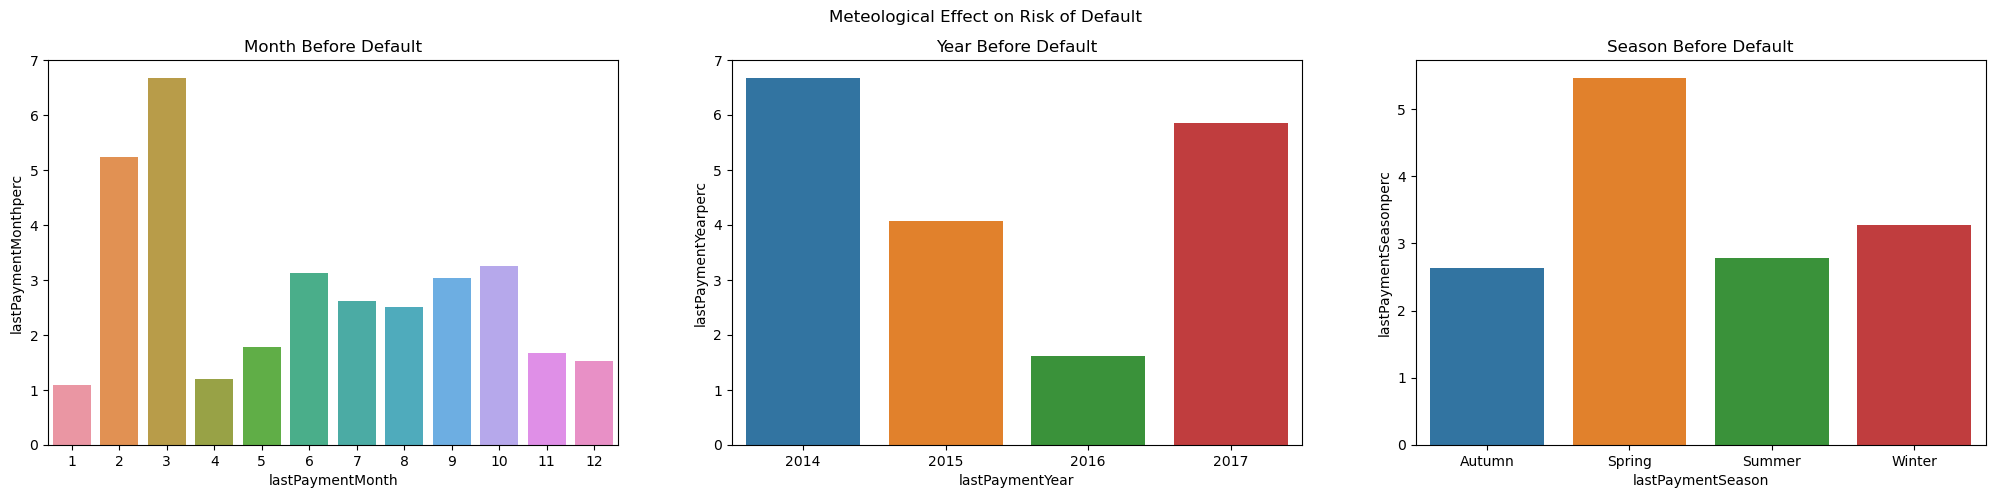

In [22]:
def summarize_profile(group, x):
    a = group.loc[group['loanStatus'] == 0, x].count() / group[x].count() * 100
    cols = [x + "perc"]
    return pd.Series([a], index=cols)

df1 = train_data.groupby('lastPaymentMonth').apply(summarize_profile, 'lastPaymentMonth').reset_index()
df2 = train_data.groupby('lastPaymentYear').apply(summarize_profile,'lastPaymentYear').reset_index()
df3 = train_data.groupby('lastPaymentSeason').apply(summarize_profile, 'lastPaymentSeason' ).reset_index()

# Plot the distribution
fig, axes = plt.subplots(1, 3, figsize=(25, 5), sharey=False)
fig.suptitle('Meteological Effect on Risk of Default')

# Month
sns.barplot(ax=axes[0], data=df1, y= 'lastPaymentMonthperc', x='lastPaymentMonth', ci=95)
axes[0].set_title("Month Before Default")

# Year
sns.barplot(ax=axes[1], data=df2, y= 'lastPaymentYearperc', x='lastPaymentYear', ci=95)
axes[1].set_title("Year Before Default")

# Season
sns.barplot(ax=axes[2], data=df3, y= 'lastPaymentSeasonperc', x='lastPaymentSeason', ci=95)
axes[2].set_title("Season Before Default")
artifact6 = fig

**lastPaymentMonth** chart shows that Feb & March have higher default rate compared to others. Lets make it ordinal such that:<br>
Other - Weight 1<br>
Feb - Weight 2<br>
March -Weight 3 <br>
**lastPaymentYear** chart shows the default rate decrease from year 2014 - 2016, but with sudden spike in year 2017. Again, lets make it ordinal.<br>
Year 2014 - 4<br>
Year 2015 - 2<br>
Year 2016 - 1<br>
Year 2017 - 3 <br>
**lastPaymentSeason** chart shows that Spring has highest default rate, while other does not  have clear impacts. We can create a boolean feature here.<br>
IsSpring - (0/1)

In [23]:
# Create ordinal feature with Month

def map_month(x):
    """
    Map Months into ordinal feature
    
    returns: weightage of month (float)
    """
    if x==2 | x==3:
        return x
    else:
        return 1

def map_year(x):
    """
    Map Year into ordinal feature
    
    returns: weightage of year (float)
    """
    if x < 2017:
        return 2016 - x + 1
    else:
        return 4

def create_isSeason(x):
    """
    Create Boolean feature
    
    returns: 0/1 (float)
    """
    if x == 'Spring':
        return 1
    else:
        return 0

train_data['lastPaymentMonth'] = train_data['lastPaymentMonth'].map(map_month)
train_data['lastPaymentYear'] = train_data['lastPaymentYear'].map(map_year)
train_data['lastPaymentSeason'] = train_data['lastPaymentSeason'].map(create_isSeason)

### Geographical Feature

Based on ranking chart below, let's create a level of 6 for **states**:
- AK, HI - Weight 5
- CO -  Weight 4
- MS, RI, LA, VA - Weight 3
- OK - Weight 2
- AL, KY - Weight 1
- Other - Weight 0

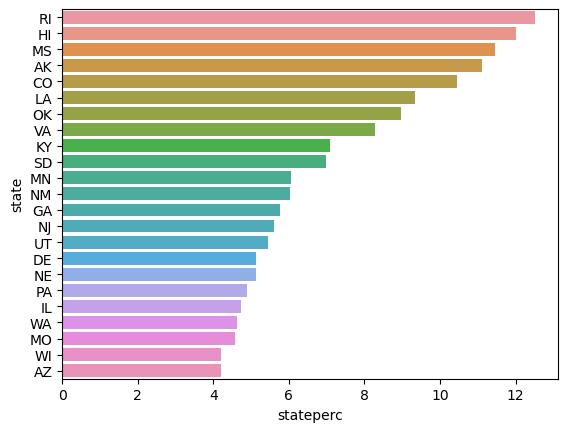

In [24]:
state_df = train_data.groupby('state').apply(summarize_profile, 'state').reset_index()
state_df = state_df.sort_values(['stateperc'], ascending=False).reset_index(drop=True)

## There are more than 40 categories of states, lets visualize part of them
artifact7 = sns.barplot(data=state_df[state_df['stateperc'] > 4], 
                        y = 'state', 
                        x = 'stateperc')

In [25]:
# Create new features Month, Year, Season
labels = {5: ["AK", "HI"], 
          4: ["CO"],
          3: ["MS", "RI", "LA", "VA"],
          2: ["OK"],
         1:["AL", "KY"]}

def map_features(x):
    """
    Rank states by default rate
    
    returns: label (str)
    """
    for k,v in labels.items():
        if x in v:
            return k
        else:
            return 0

train_data['state'] = train_data['state'].map(map_features)

### Payment Behaviour

Create features based on borrower's payment behaviour:
1. Convert 5 categories **payFrequency** into numerical days.
2. Calculate **expectedDaysUntilPayoff** based on Average Installment Amount Per Pay

In [26]:
# Create New Features 'totalPayFrequency'
train_data['totalPayFrequency'] = train_data['originallyScheduledPaymentAmount'] / train_data['avgInstallmentAmountPerPayFrequency']
train_data.loc[~np.isfinite(train_data['totalPayFrequency']), 'totalPayFrequency'] = 0 
# Mapping for payFrequency Category column
labels = {'B': 14,  # Biweekly = 14 days
          'I': 1,   # Irregular = assume 1 days
          'M': 30,  # Monthly = 30 days or 31 days
          'S': 15,  # Semi Monthly = 15 days
          'W': 7}   # Weekly = 7 days

def map_pay_frequency(x):
    """
    Check if payFrequency present in the labels dict
    params:
    x = payFrequency, str
    
    returns: label (int)
    """
    for k,v in labels.items():
        if x in k:
            return v
        else:
            assert "Couldn't find right mapping for " + x

# Convert 'payFrequency' from categorical into numerical
train_data['payFrequency'] = train_data['payFrequency'].apply(map_pay_frequency)

# What is the expected number of days until fully payoff?
train_data['expectedDaysUntilPayoff'] = train_data['payFrequency'] * train_data['totalPayFrequency']

Text(0.5, 0, 'Expected Days Until Payoff')

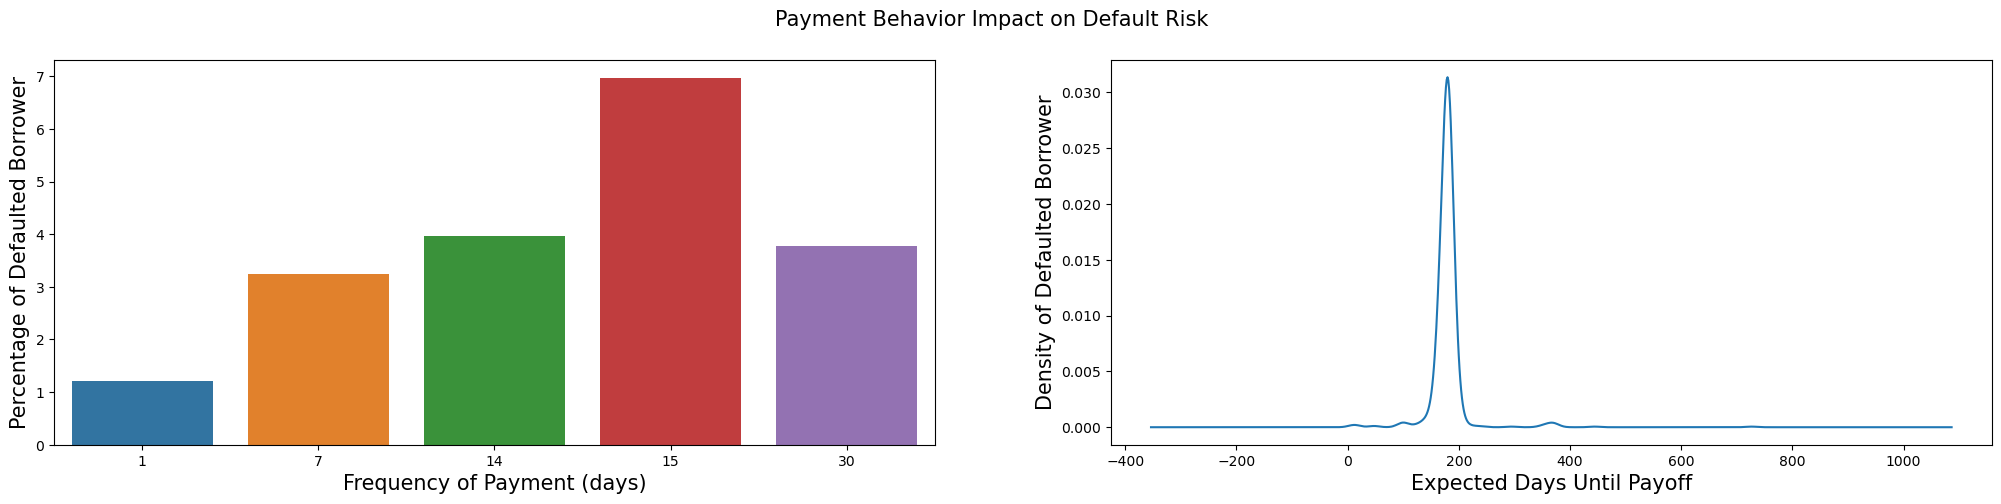

In [27]:
payment_behaviour_df = train_data.groupby('payFrequency').apply(summarize_profile, 'payFrequency').reset_index()
payment_behaviour_df = payment_behaviour_df.sort_values(['payFrequencyperc'], ascending=False).reset_index(drop=True)

# Plot the distribution
fig, axes = plt.subplots(1, 2, figsize=(25, 5), sharey=False)
fig.suptitle('Payment Behavior Impact on Default Risk', fontsize = 15)

## Payfrequency vs Percentage of Defaulted Borrower
ax = sns.barplot(ax=axes[0],
                 data=payment_behaviour_df, 
                 x = 'payFrequency', 
                 y = 'payFrequencyperc')
ax.set_ylabel('Percentage of Defaulted Borrower', fontsize = 15)
ax.set_xlabel('Frequency of Payment (days)', fontsize = 15)
artifact8 = ax

## expectedDaysUntilPayoff vs Percentage of Defaulted Borrower
ax2 = train_data[train_data['loanStatus']==False]['expectedDaysUntilPayoff'].plot.kde()
ax2.set_ylabel('Density of Defaulted Borrower', fontsize = 15)
ax2.set_xlabel('Expected Days Until Payoff', fontsize = 15)

Seems most features here doesn't have clear linear relationship with default risk. Given detailed personal data **(eg. age, occupation, income, noOfDependents, rentOrOwnedHourse, etc)**, I believed it would have more valuable insight.

Next, we are going to analyze **fpStatus** impacts on individuals default risk

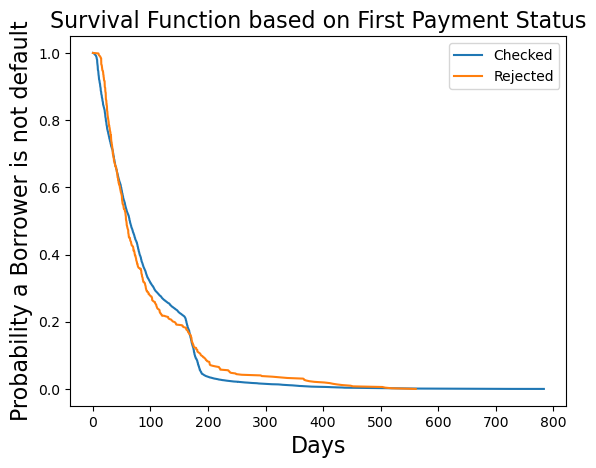

In [28]:
# Define isLead
Checked = train_data.fpStatus == 'Checked'
Rejected = train_data.fpStatus == 'Rejected'
# Plot the survival function
ax = plt.subplot()
kmf = KaplanMeierFitter()
kmf.fit(durations=train_data[Checked].survivalDuration, event_observed=train_data[Checked].loanStatus, label='Checked')
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=train_data[Rejected].survivalDuration, event_observed=train_data[Rejected].loanStatus, label='Rejected')
kmf.survival_function_.plot(ax=ax)
plt.title('Survival Function based on First Payment Status', size = 16)
ax.set_xlabel('Days', size = 16)
ax.set_ylabel('Probability a Borrower is not default', size = 16)
plt.show()
artifact9 = plt

However, in the fpStatus plot, **Checked** and **Rejected** survival curves go almost head to head which makes it difficult to understand whether if there is a difference or not. To investigate this, we can run a log-rank hypothesis test.<br>
Having null hypothesis indicating **Checked** and **Rejected** survival curves are identical and alternative hypothesis indicating they are not identical. If the p-value of the log-rank test is lower than 0.05 we can reject the null hypothesis.

In [29]:
from lifelines.statistics import logrank_test
# Define logrank test
output = logrank_test(
    durations_A = train_data[Checked].survivalDuration,
    durations_B = train_data[Rejected].survivalDuration,
    event_observed_A = train_data[Checked].loanStatus,
    event_observed_B = train_data[Rejected].loanStatus
)
output.print_summary

<bound method StatisticalResult.print_summary of <lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.26 0.13      2.91>

p-value is greater than 0.05, we **do not reject the hypothesis** of Checked and Rejected First Payment survival curves are identical.

In [30]:
# Convert 'fpStatus' from categorical into numerical
train_data['fpStatus'] = train_data['fpStatus'].apply(lambda x: 1 if x=='Checked' else 0)

### Lead Type

Since **lead** is dominant over other lead methodology, we can create binary feature: **isLead (0/1)**

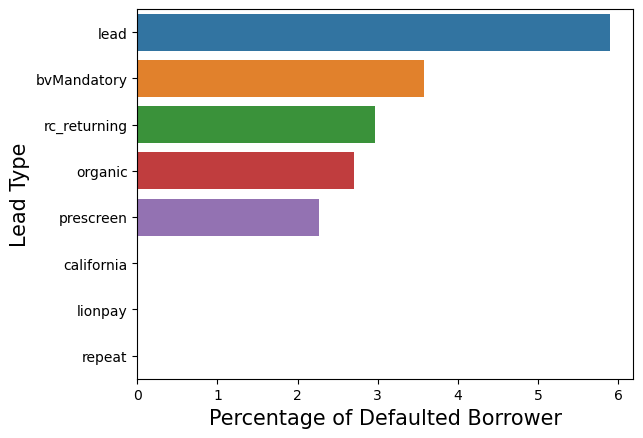

In [31]:
lead_df = train_data.groupby('leadType').apply(summarize_profile, 'leadType').reset_index()
lead_df = lead_df.sort_values(['leadTypeperc'], ascending=False).reset_index(drop=True)

## Payfrequency vs Percentage of Defaulted Borrower
ax = sns.barplot(data=lead_df, 
                 y = 'leadType', 
                 x = 'leadTypeperc')
ax.set_xlabel('Percentage of Defaulted Borrower', fontsize = 15)
ax.set_ylabel('Lead Type', fontsize = 15)
artifact10 = ax

From Kaplan univariate analysis, we can see that individuals with leadType of **'Lead'** have lower probabilities of not default compared with others

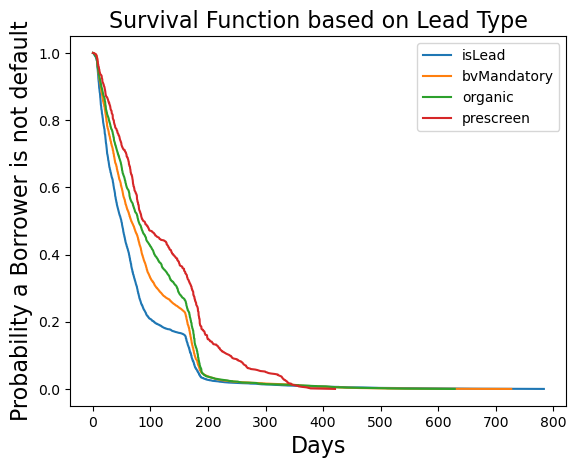

In [32]:
# Define isLead
isLead = train_data.leadType == 'lead'
bvMandatory = train_data.leadType == 'bvMandatory'
organic = train_data.leadType == 'organic'
prescreen = train_data.leadType == 'prescreen'
# Plot the survival function
ax = plt.subplot()
kmf = KaplanMeierFitter()
kmf.fit(durations=train_data[isLead].survivalDuration, event_observed=train_data[isLead].loanStatus, label='isLead')
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=train_data[bvMandatory].survivalDuration, event_observed=train_data[bvMandatory].loanStatus, label='bvMandatory')
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=train_data[organic].survivalDuration, event_observed=train_data[organic].loanStatus, label='organic')
kmf.survival_function_.plot(ax=ax)
kmf.fit(durations=train_data[prescreen].survivalDuration, event_observed=train_data[prescreen].loanStatus, label='prescreen')
kmf.survival_function_.plot(ax=ax)
plt.title('Survival Function based on Lead Type', size = 16)
ax.set_xlabel('Days', size = 16)
ax.set_ylabel('Probability a Borrower is not default', size = 16)
plt.show()
artifact11 = ax

In [33]:
# Convert 'payFrequency' from categorical into numerical
train_data['leadType'] = train_data['leadType'].apply(lambda x: 1 if x=='lead' else 0)

## Features Selection

### Column Selection

Remove features that are not useful for modelling: 
1. single occurence data: originated, approved, isFunded
2. IDs
3. Dates

In [34]:
train_data = train_data.drop(['originated', 'approved', 'isFunded', # single occurence
                             'loanId', 'anon_ssn', 'underwritingid', 'clarityFraudId', # IDs
                             'applicationDate', 'originatedDate', 'lastPaymentDate'], # Dates
                             axis=1)

### CoxPH Feature Importances

Feature Selection Using CoxPH Model

In model summary, **exp(coef)** is the hazard ratio which indicates how much the baseline default risk changes due to one-unit change in the corresponding factor. For example, if payFrequency satisfaction changes one unit:
- default risk ratio: 0.97
- default risk change: 0.97–1 = -0.03
- survival time change: (1/0.97)-1 = 0.03 → 3% increase in survival time

p value here indicates significance of factor variables. Here **apr**, **state** and **originallyScheduledPaymentAmount** are not significant. 

In [35]:
from lifelines import CoxPHFitter
train_data2 = train_data.replace(np.nan, 0)
train_data2 = train_data2.drop(['balanceOnLastDay'], # Dates
                             axis=1)
# Initialize and fit the model
coxph = CoxPHFitter()
coxph.fit(train_data2, duration_col='survivalDuration', event_col='loanStatus')
# Print model summary
coxph.print_summary()

<lifelines.CoxPHFitter: fitted with 19104 total observations, 746 right-censored observations>
             duration col = 'survivalDuration'
                event col = 'loanStatus'
      baseline estimation = breslow
   number of observations = 19104
number of events observed = 18358
   partial log-likelihood = -154463.66
         time fit was run = 2023-07-19 03:56:42 UTC

---
                                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                                   
payFrequency                         -0.03       0.97       0.00            -0.03            -0.02                 0.97                 0.98
apr                                  -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
nPaidOff                              0.08       1.08       0.01             0.06             0.09                 1.06                 1.10
loanAmount                           -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
originallyScheduledPaymentAmount     -0.00       1.00       0.00            -0.00             0.00                 1.00                 1.00
state                                 0.01       1.01       0.03            -0.05             0.07                 0.95                 1.08
leadType                              0.30       1.36       0.02             0.26             0.35                 1.29                 1.42
leadCost                             -0.01       0.99       0.00            -0.01            -0.00                 0.99                 1.00
fpStatus                              0.86       2.36       0.04             0.79             0.93                 2.19                 2.54
hasCF                                 0.63       1.88       0.05             0.54             0.73                 1.71                 2.07
noOfInstallmentMade                  -0.22       0.80       0.00            -0.23            -0.22                 0.80                 0.80
avgInstallmentAmountPerPayFrequency   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
clearfraudscore                      -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
lastPaymentMonth                     -0.17       0.84       0.02            -0.20            -0.14                 0.82                 0.87
lastPaymentYear                       0.08       1.08       0.01             0.07             0.09                 1.07                 1.10
lastPaymentSeason                     0.26       1.30       0.03             0.21             0.32                 1.23                 1.37
totalPayFrequency                     0.06       1.06       0.00             0.06             0.07                 1.06                 1.07
expectedDaysUntilPayoff              -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                                      cmp to       z      p   -log2(p)
covariate                                                             
payFrequency                            0.00  -12.77 <0.005     121.66
apr                                     0.00   -0.74   0.46       1.13
nPaidOff                                0.00    9.66 <0.005      70.90
loanAmount                              0.00   -2.55   0.01       6.55
originallyScheduledPaymentAmount        0.00   -0.11   0.91       0.14
state                                   0.00    0.28   0.78       0.36
leadType                                0.00   12.52 <0.005     117.09
leadCost                                0.00  -10.46 <0.005      82.58
fpStatus                                0.00   22.88 <0.005     382.44
hasCF          

## Pipeline Creation

For any missing values in numerical variables, we will use IterativeImputer from SKLearn module.<br>
**IterativeImputer** is a strategy for imputing missing values by modeling each feature with missing values as a function of other features in a round-robin fashion.<br>
As for any missing values in categorical variables, we will impute using most frequent occurence data.<br>
For scaling, we use **StandardScaler** to standardize features by removing the mean and scaling to unit variance.

In [36]:
numeric_transformer = Pipeline(steps=[
    ('imputer', IterativeImputer(random_state = 1)),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder())
])

numeric_features = ['payFrequency', 'apr', 'nPaidOff', 'loanAmount',
                   'originallyScheduledPaymentAmount', 'state', 'leadType', 'leadCost',
                   'hasCF', 'noOfInstallmentMade', 'avgInstallmentAmountPerPayFrequency',
                   'clearfraudscore', 'lastPaymentMonth',
                   'lastPaymentYear', 'lastPaymentSeason', 'totalPayFrequency',
                   'expectedDaysUntilPayoff', 'fpStatus']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
    ]
)

rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=2,
                           min_samples_leaf=3,
                           max_features="sqrt",
                           n_jobs=6,
                           random_state=1,
                           verbose=1)

pipe = Pipeline([
    ('feature_engineering', PipelineFeatureTransformer()),
    ('preprocessor', preprocessor),
    ('randomForestSurival', rsf)
])

SKLearn Pipeline is created to schedule similar operations on different datasets.<br>
**Features Engineering** -> **Preprocessing (Missing Value Imputation -> Scaling -> One Hot Encoding)** -> **Model Training**

## Model Training

### Oversampling

Before we start model training, let's implement oversampling on minority category of Defaulted Borrowers.

In [37]:
# Oversampling using SKlearn module
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(master_data.drop(['loanStatus'], axis=1), master_data['loanStatus'].values)

train_data_resampled = pd.DataFrame(X_resampled, columns=X_resampled.columns.tolist())
train_data_resampled['loanStatus'] = y_resampled
X_resampledSRF, y_resampledSRF = get_x_y_survival(train_data_resampled, 'loanStatus', 'survivalDuration', 1)

C:\Users\asust\AppData\Local\Temp\ipykernel_1196\2025152796.py:6: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y = np.empty(dtype=[(col_event, np.bool), (col_time, np.float64)],


Before oversampling, Non-default borrowers occupied 96.1% of the total population

In [38]:
# Count the number of Class = Default / Not Default Before oversampling
neg, pos = np.bincount(master_data['loanStatus'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 31842
    Positive: 30618 (96.16% of total)



After oversampling, 50:50 population is achieved. Issue with imbalanced data is now solved!

In [39]:
# Count the number of Class = Default / Not Default Before oversampling
neg, pos = np.bincount(y_resampled)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 61236
    Positive: 30618 (50.00% of total)



<AxesSubplot:xlabel='count', ylabel='loanStatus'>

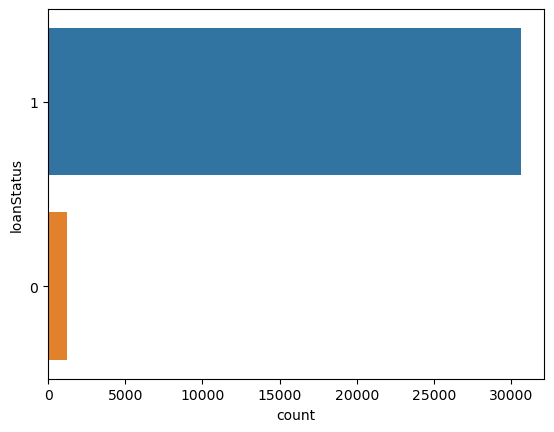

In [40]:
sns.countplot(data=master_data, 
                          y='loanStatus',
                          order = master_data['loanStatus'].value_counts().index)

### Random Survival Forest

Due to large computational power/memory is needed to predict the survival function of each borrowers, we will do train for the first 10000 shuffled data <br>

In [41]:
estimator = pipe.fit(X_resampledSRF[:2000], y_resampledSRF[:2000])

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.8s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    1.0s finished


The predicted risk scores indicate that risk for the 212 out of 500 borrowers is quite a bit higher than the rest.

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


0


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.2s finished


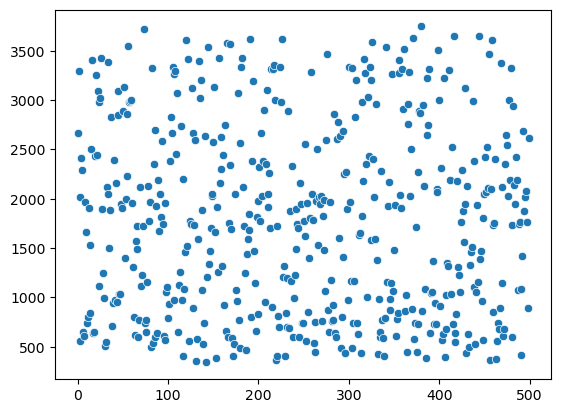

In [42]:
y_pred = pipe.predict(X_test.iloc[:500])
print(np.count_nonzero(y_pred > 10000))
artifact12 = sns.scatterplot(data=y_pred)

Let's plot the survival function for first 5 borrowers

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.0s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.0s finished


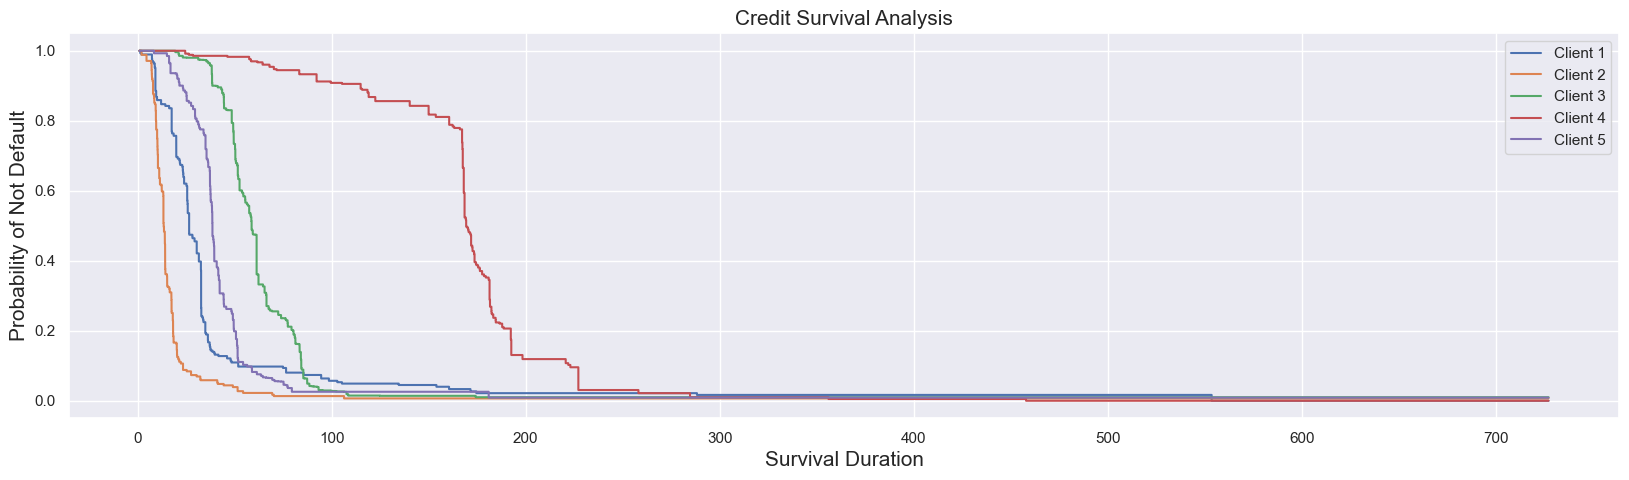

In [46]:
i=1
chf_funcs = estimator.predict_survival_function(X_test.iloc[:5])
survivalPredictionPlot = sns.set(rc={"figure.figsize":(20, 5)})
for fn in chf_funcs:
    survivalPredictionPlot = sns.lineplot(x=fn.x, y=fn(fn.x), drawstyle='steps-pre', label='Client ' + str(i))
    i=i+1
    
plt.xlabel('Survival Duration', fontsize = 15)
plt.ylabel('Probability of Not Default', fontsize = 15)
plt.title('Credit Survival Analysis', fontsize = 15)
plt.legend()
plt.show()
artifact13 = survivalPredictionPlot

In [47]:
concordance_index = estimator.score(X_test[:500], y_test[:500])
concordance_index

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:    0.1s finished


0.8985074877020673

### CoxPH

Predicted survival probability of borrower n.36 after 10 more years is 80% however it is 53% for employee n.4.

In [48]:
pipeCoxPH = Pipeline([
    ('feature_engineering', PipelineFeatureTransformer()),
    ('preprocessor', preprocessor),
])
x = pipeCoxPH.fit(X_resampledSRF, X_resampledSRF)
x_new = x.fit_transform(X_test, y_test)
df_new = pd.DataFrame(x_new, columns=numeric_features)
df_new['loanStatus'] = [i[0] for i in y_test]
df_new['survivalDuration'] = [j[1] for j in y_test]

# Current employees
df_new = df_new.loc[df_new['loanStatus'] == False]
# Years at the company of current employees
df_new_obs = df_new['survivalDuration']
# Predict survival probabilities 
predicted = coxph.predict_survival_function(df_new,conditional_after=df_new_obs)

At 0.64 days, the probability of not default is 96.7% fror borrower no.36

In [49]:
predicted.head(5)

,36,96,102,105,112,128,135,170,198,205,...,6062,6069,6101,6204,6210,6246,6278,6288,6305,6327
0.640822,0.967322,0.907248,0.960650,0.966609,0.963597,0.971840,0.979346,0.989710,0.842073,0.970448,...,0.999594,0.923748,0.894987,0.971134,0.972943,0.989443,0.950673,0.971701,0.962761,0.965828
0.665479,0.966651,0.907026,0.956009,0.965888,0.961894,0.970825,0.978911,0.989615,0.840409,0.969899,...,0.999570,0.923421,0.892290,0.970758,0.972560,0.989398,0.949684,0.970422,0.960925,0.965646
0.680530,0.965901,0.906891,0.954535,0.965466,0.961684,0.970521,0.978203,0.989558,0.837507,0.969028,...,0.999548,0.923155,0.891683,0.970623,0.972327,0.989371,0.949494,0.970060,0.956014,0.965559
0.682011,0.965820,0.906878,0.954465,0.965447,0.961684,0.970480,0.978164,0.989552,0.837444,0.969010,...,0.999545,0.923129,0.891623,0.970605,0.972304,0.989368,0.949426,0.970006,0.955826,0.965551
0.752656,0.962116,0.904177,0.945256,0.964774,0.959406,0.967668,0.973483,0.989348,0.831639,0.964424,...,0.999434,0.920508,0.886544,0.968019,0.971216,0.989097,0.936555,0.961629,0.949484,0.964697


At days 13. the probability of customer 36 not default drops drastically to 28%.<br>
At days 13, the probability of customer 6062 not default still maintain at 98%.<br>

In [50]:
predicted.iloc[2000:2005]

,36,96,102,105,112,128,135,170,198,205,...,6062,6069,6101,6204,6210,6246,6278,6288,6305,6327
13.064503,0.283268,0.184259,0.253871,0.446385,0.373887,0.417696,0.447077,0.808386,0.078335,0.452561,...,0.987625,0.313492,0.123939,0.540889,0.638660,0.807438,0.230342,0.512252,0.387116,0.526571
13.071533,0.283012,0.183854,0.253840,0.446212,0.373666,0.417595,0.446576,0.808289,0.078251,0.452398,...,0.987622,0.313372,0.123939,0.540538,0.638420,0.807224,0.230318,0.511804,0.387086,0.526444
13.072835,0.282964,0.183810,0.253834,0.446190,0.373625,0.417577,0.446553,0.808273,0.078235,0.452368,...,0.987621,0.313372,0.123939,0.540306,0.638367,0.807186,0.230318,0.511610,0.387077,0.526422
13.075887,0.282509,0.183679,0.253821,0.446140,0.373529,0.417533,0.446498,0.808235,0.077997,0.452301,...,0.987620,0.313372,0.123939,0.540115,0.638242,0.807153,0.230318,0.511396,0.387057,0.526369
13.083216,0.282024,0.183387,0.253788,0.445832,0.373299,0.417330,0.446229,0.808144,0.077806,0.452142,...,0.987617,0.313372,0.123662,0.539756,0.637942,0.807098,0.230318,0.511396,0.387007,0.525983


## Deployment

### Predict loanStatus

In [51]:
def deploy(model, modelName, evaluationResult):
    mlflow.set_tracking_uri("http://localhost:5000")
    mlflow.set_experiment("Credit Risk Analytic")

    with mlflow.start_run() as run:
        run_num = run.info.run_id
        model_uri = "runs:/{run_id}/{artifact_path}".format(run_id=run_num, artifact_path=modelName)
        mlflow.log_param('best_algorithm', modelName)
        mlflow.log_param('target_variable', 'Survival Function')
        mlflow.log_param('numeric_features', master_data.select_dtypes(include=['int','float']).columns.tolist())
        mlflow.log_param('categorical_features', master_data.select_dtypes(include=['object']).columns.tolist())
        mlflow.log_param('holdout_ratio', 0.2)
        mlflow.log_param('split_ratio', 0.2)
        mlflow.log_param('scaler', 'StandardScaler')
        mlflow.log_param('Imputer', 'IterativeImputer')
        mlflow.log_metrics({"Concordance Index" : evaluationResult})
        mlflow.sklearn.log_model(model, modelName)

        # Store plots as artifacts
        artifact_folder = Path("./temp/")  # Creating temp artifact folder
        artifact_folder.mkdir(parents=True, exist_ok=True)
        artifact1.figure.savefig(Path(artifact_folder, "EDA1.png"))
        artifact2.figure.savefig(Path(artifact_folder, "EDA2.png"))
        artifact3.figure.savefig(Path(artifact_folder, "EDA3.png"))
        artifact4.figure.savefig(Path(artifact_folder, "EDA4.png"))
        artifact7.figure.savefig(Path(artifact_folder, "EDA7.png"))
        artifact8.figure.savefig(Path(artifact_folder, "EDA8.png"))
        artifact10.figure.savefig(Path(artifact_folder, "EDA10.png"))
        artifact11.figure.savefig(Path(artifact_folder, "EDA11.png"))
        artifact12.figure.savefig(Path(artifact_folder, "Result1.png"))
        artifact13.figure.savefig(Path(artifact_folder, "Result2.png"))
        
        mlflow.log_artifacts(artifact_folder, artifact_path="evaluation_artifacts")
        shutil.rmtree(artifact_folder)  # Deleting temp folder

        model_details = mlflow.register_model(
            model_uri=model_uri,
            name=modelName
        )

    client = MlflowClient()
    model_version_infos = client.search_model_versions("name = '%s'" % modelName)
    new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

    def wait_model_transition(model_name, model_version, stage):
        client = MlflowClient()
        for _ in range(10):
            model_version_details = client.get_model_version(
                name=model_name,
                version=model_version,
            )
            status = ModelVersionStatus.from_string(model_version_details.status)
            print("Model status: %s" % ModelVersionStatus.to_string(status))
            if status == ModelVersionStatus.READY:
                client.transition_model_version_stage(
                    name=model_name,
                    version=model_version,
                    stage=stage,
                )
                break
            time.sleep(1)

    try:
        wait_model_transition(modelName, int(new_model_version)-1, "None")
    except:
        pass

    wait_model_transition(modelName, new_model_version, "Staging")

    client.update_model_version(
        name=modelName,
        version=new_model_version,
        description="This model is a random forest classifier for the credit risk dataset from Banking Institution X."
    )

    mlflow.end_run()

In [58]:
deploy(estimator, 'Random Survival Forest', concordance_index)
deploy(coxph, 'CoxPH', coxph.concordance_index_)

2023/07/19 12:10:17 INFO mlflow.tracking.fluent: Experiment with name 'Credit Risk Analytic' does not exist. Creating a new experiment.
2023/07/19 12:10:25 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: C:\Users\asust\AppData\Local\Temp\tmp6_ibfwz9\model\model.pkl, flavor: sklearn), fall back to return ['scikit-learn==1.0.2', 'cloudpickle==1.6.0']. Set logging level to DEBUG to see the full traceback.
C:\Users\asust\anaconda3\lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Random Survival Forest'.
2023/07/19 12:10:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: Random Survival Forest, version 1
Created version '1' of model 'Random Survival Forest'.


Model status: READY


2023/07/19 12:10:27 WARNING mlflow.sklearn: Model was missing function: predict. Not logging python_function flavor!
Successfully registered model 'CoxPH'.
2023/07/19 12:10:31 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: CoxPH, version 1


Model status: READY


Created version '1' of model 'CoxPH'.


In [59]:
!mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0

^C


Please open your browser and navigate to http://localhost:5000/ in order to view MLFlow.

## Conclusion

In this notebook, we have answered some of the important questions lenders might have about the risk of default. We used Kaplan-Meier fitter to calculate and plot survival probabilities and Cox-PH model & Random Survival Forest model to predict the survival probabilities of current employees for next years. These predictions are very insightful as they let us know which factors decrease and increase default probabilities and who are the borrowers at risk in the short term. Using these predictions companies can put extra effort to prevent default at the time.

**Way Forward**
- We can further improve the model by having personal detailed data rg. Age, salary, job industries, no. of dependent, renting or bought house, etc, which may provide good insight on borrower financial situation.
- We can also try out with Deep Learning model eg. DeepSurv & DeepHit for Survival Analysis. (Unfortunately this type of deep learning requires enormous amount of computation power, in which we are unable to demonstate it here.
- We can further tune the hyperparameter using GridSearchCV to find optimal fit to model.

Thank you for your time! And please provide any feedback for further improvement!